<a href="https://colab.research.google.com/github/Sonali2824/age_and_gender_prediction/blob/main/age_gender_evaluation_model_B_84%25_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [1]:
#
# Add your code here
#
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

Number of files in train_val/:5000
Size of Image: 128 128 3


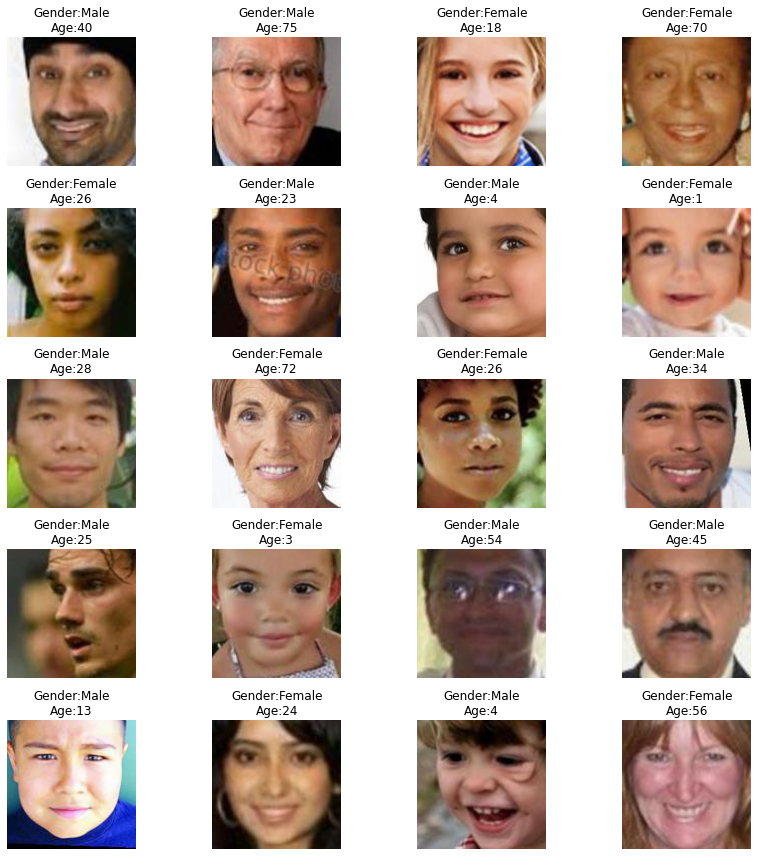

In [2]:
#
# Add your code here
#
import os
import matplotlib.pyplot as plt

folder = '/content/drive/MyDrive/train_val'
#Checking if there are 5000 training files
num_files = len([f for f in os.listdir(folder)if os.path.isfile(os.path.join(folder, f))])
print("Number of files in train_val/:%d" % (num_files))  

fig, axs = plt.subplots(5, 4, figsize=(12, 12))
axs = axs.ravel()

for i, filename in enumerate(os.listdir(folder)):
    if i == 20:
        break
    if i == 0:
      filepath = os.path.join(folder, filename)
      img = plt.imread(filepath)
      height, width, channels = img.shape
      print("Size of Image:", height, width, channels)

    filepath = os.path.join(folder, filename)
    img = plt.imread(filepath)
    axs[i].imshow(img)
    substrings = filename.split('_')
    if substrings[1] == "0":
      gender = "Male"
    else:
      gender = "Female"
    axs[i].axis('off')
    axs[i].set_title(f'Gender:{gender}\nAge:{substrings[0]}')

plt.tight_layout()
plt.show()


## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [3]:
#
# Add your code here
#
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array


image_files = os.listdir(folder)

#Obtaining the x, y_age and y_gender lists from the dataset
x = []
y_age = []
y_gender = []

for images in image_files:
    label = images.split('_')
    age = int(label[0])
    gender = int(label[1])
    img = load_img(folder+"/"+images)
    img = img_to_array(img)
    x.append(img)
    y_age.append(age)
    y_gender.append(gender)
    
x = np.array(x)
y_age = np.array(y_age)
y_gender = np.array(y_gender)

#Normalizing images as per instructions in Step 1 point 1
x = x / 255.0

In [4]:
#Splitting ten data into training and validation sets
split = int(len(x) * 0.80) #Using 20% as validation set

x_train, y_train = x[:split], [y_age[:split], y_gender[:split]]
x_val, y_val = x[split:], [y_age[split:], y_gender[split:]]

## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [5]:
#
# Add your code here
#
#Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

#Defining train_datagenerator to perform augmentation on one image and display the results in the next cell
train_datagenerator = ImageDataGenerator(
          width_shift_range=.10,
          height_shift_range=.10,
          rotation_range=30,
          horizontal_flip=True)

#Defining augmentation for the train dataset
def generate_train_data_augmentation(x, y):
  train_datagenerator = ImageDataGenerator(
            width_shift_range=.10,
            height_shift_range=.10,
            rotation_range=30,
            horizontal_flip=True)

  age_generated = train_datagenerator.flow(x, y[0], batch_size=32, seed = 1)
  gender_generated = train_datagenerator.flow(x, y[1], batch_size=32, seed = 1)

  while True:
    X1 = age_generated.next()
    X2 = gender_generated.next()
    yield X1[0], (X1[1], X2[1])

# create generator
train_generated = generate_train_data_augmentation(x_train,[y_train[0], y_train[1]])


******************* Data Augmentation on One Image ************************************



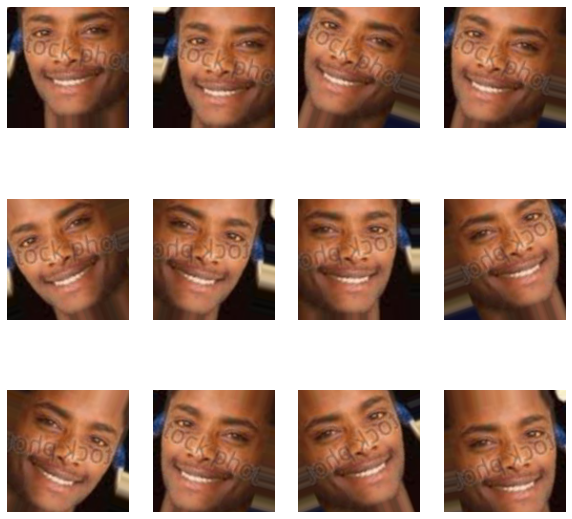

In [6]:
import matplotlib.pyplot as plt
import cv2
import keras.utils as image
from tensorflow.keras.utils import array_to_img

# Get a batch of 12 augmented images
x_batch, y_batch = next(train_generated)

# Display the images
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    # Convert the image array to an image object and display it
    ax.imshow(image.array_to_img(x_batch[i]), cmap="gray")

    if y_batch[1][i] == 0:
      gender = "Male"
    else:
      gender = "Female"
    ax.axis('off')
    ax.set_title(f'Gender:{gender}\nAge:{y_batch[0][i]}')
    

plt.tight_layout()
plt.show()


print()
print("******************* Data Augmentation on One Image ************************************")
print()

image_files = os.listdir(folder)
selected_image = image_files[5]
selected_image = image.load_img((folder+"/"+selected_image), target_size=(128,128)) # resize it
selected_image = image.img_to_array(selected_image)
selected_image = selected_image.reshape((1,)+selected_image.shape) 
i = 0
plt.figure(figsize=(10,10))
for batch in train_datagenerator.flow(selected_image,batch_size=1):
  plt.subplot(3,4,i+1)
  plt.axis("off")
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i%12 == 0:
    break
plt.show()

## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 126, 126, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 63, 63, 32)  0           ['conv2d_94[0][0]']              
                                                                                            

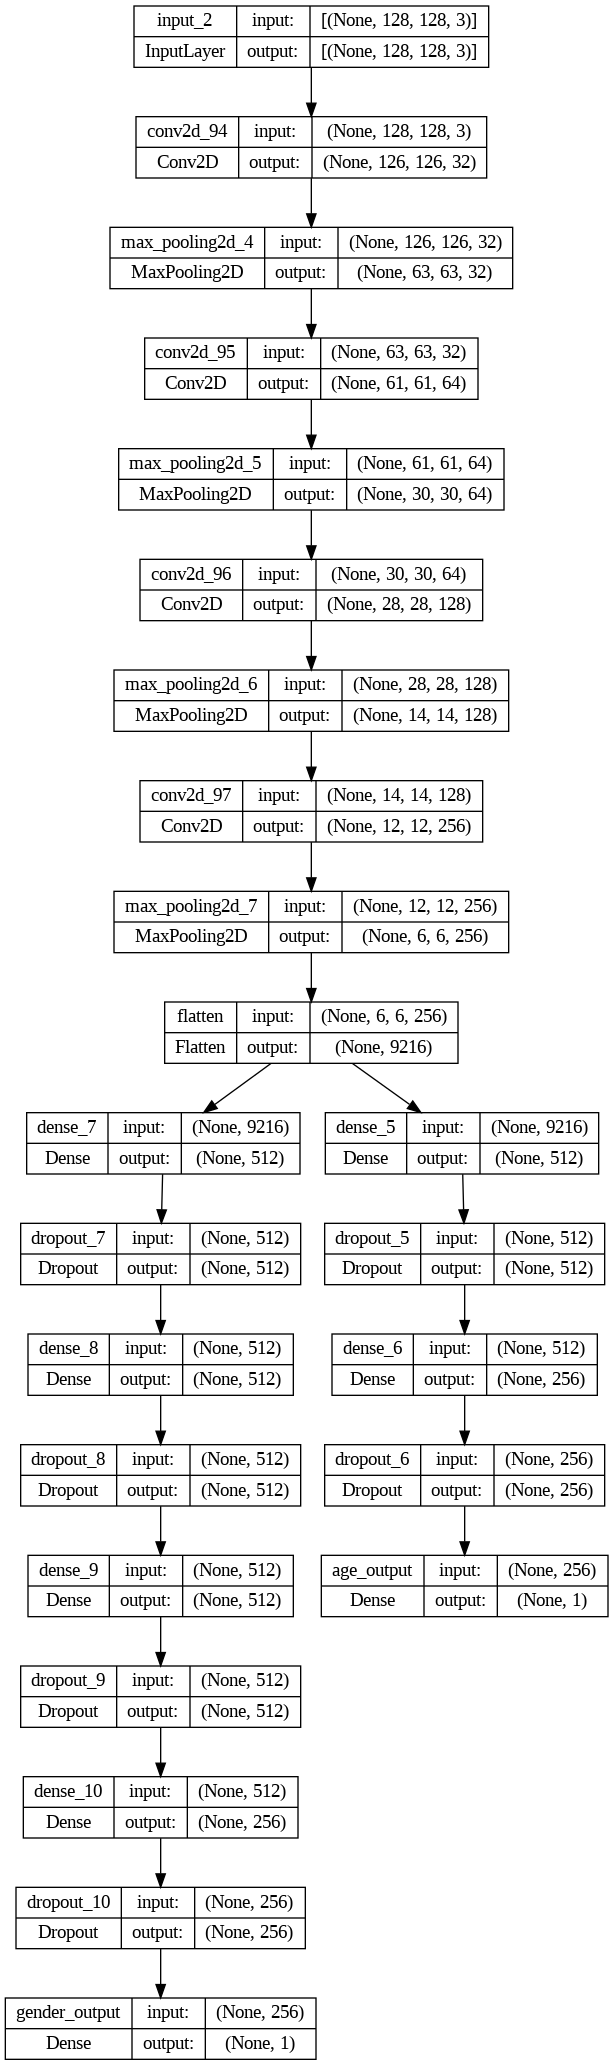

In [ ]:
#
# Add your code here
#
from keras.models import Model
from keras.layers import Input,Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Concatenate

input_layer = Input(shape=(128, 128, 3))

convolution_layer_1= Conv2D(32, kernel_size=(3,3), activation = 'relu') (input_layer)
max_pooling_1 = MaxPooling2D(pool_size=(2,2)) (convolution_layer_1)

convolution_layer_2= Conv2D(64, kernel_size=(3,3), activation = 'relu') (max_pooling_1)
max_pooling_2 = MaxPooling2D(pool_size=(2,2)) (convolution_layer_2)

convolution_layer_3= Conv2D(128, kernel_size=(3,3), activation = 'relu') (max_pooling_2)
max_pooling_3 = MaxPooling2D(pool_size=(2,2)) (convolution_layer_3)

convolution_layer_4= Conv2D(256, kernel_size=(3,3), activation = 'relu') (max_pooling_3)
max_pooling_4 = MaxPooling2D(pool_size=(2,2)) (convolution_layer_4)

flatten = Flatten()(max_pooling_4)

dense_1 = Dense(512, activation='relu')(flatten)
dropout_1 = Dropout(0.1) (dense_1)
dense_1 = Dense(256, activation='relu')(dropout_1)
dropout_1 = Dropout(0.1) (dense_1)
output_1 = Dense(1, activation='linear', name='age_output') (dropout_1)

dense_2 = Dense(512, activation='relu')(flatten)
dropout_2 = Dropout(0.1) (dense_2)
dense_2 = Dense(512, activation='relu')(dropout_2)
dropout_2 = Dropout(0.1) (dense_2)
dense_2 = Dense(512, activation='relu')(dropout_2)
dropout_2 = Dropout(0.1) (dense_2)
dense_2 = Dense(256, activation='relu')(dropout_2)
dropout_2 = Dropout(0.1) (dense_2)
output_2 = Dense(1, activation='sigmoid', name='gender_output') (dropout_2)



modelA = Model(inputs=input_layer, outputs = [output_1,output_2])

modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [ ]:
#
# Add your code here
#
#Compile the Code
modelA.compile(optimizer='adam', 
              loss={
                  'age_output': 'mean_squared_error', 
                  'gender_output': 'binary_crossentropy'},
              metrics={
                  'age_output': 'MAE', 
                  'gender_output': 'accuracy'})

#Fitting the Model
batch_size = 32
history = modelA.fit(train_generated,
                        steps_per_epoch= x_train.shape[0] // batch_size,
                        epochs=150,
                        validation_data=(x_val, (y_val[0],y_val[1])))


In [ ]:
import os

model_folder = '/content/drive/MyDrive/Colab Notebooks/models'
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
modelA.save(model_folder+'/age_gender_A.h5')  

In [ ]:
#Utlising keras tuner to help choose hyperparameters

!pip install -U keras-tuner
from kerastuner import HyperModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.applications import VGG16, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Concatenate, GlobalAveragePooling2D

def build_model(hp):
  input_layer = Input(shape=(128, 128, 3))

  convolution_layer_1= Conv2D(hp.Choice('convolution_layer_1', values=[32, 64, 128], default=32), kernel_size=(3,3), activation = 'relu', kernel_regularizer=l2(hp.Float('reg_1', min_value=0.01, max_value=0.05, default=0.01, step=0.01))) (input_layer)
  max_pooling_1 = MaxPooling2D(pool_size=(2,2)) (convolution_layer_1)

  convolution_layer_2= Conv2D(hp.Choice('convolution_layer_2', values=[32, 64, 128], default=64), kernel_size=(3,3), activation = 'relu', kernel_regularizer=l2(hp.Float('reg_2', min_value=0.01, max_value=0.05, default=0.01, step=0.01))) (max_pooling_1)
  max_pooling_2 = MaxPooling2D(pool_size=(2,2)) (convolution_layer_2)

  convolution_layer_3= Conv2D(hp.Choice('convolution_layer_3', values=[32, 64, 128], default=128), kernel_size=(3,3), activation = 'relu', kernel_regularizer=l2(hp.Float('reg_3', min_value=0.01, max_value=0.05, default=0.01, step=0.01))) (max_pooling_2)
  max_pooling_3 = MaxPooling2D(pool_size=(2,2)) (convolution_layer_3)

  convolution_layer_4= Conv2D(hp.Choice('convolution_layer_4', values=[64, 128, 256], default=256), kernel_size=(3,3), activation = 'relu', kernel_regularizer=l2(hp.Float('reg_4', min_value=0.01, max_value=0.05, default=0.01, step=0.01))) (max_pooling_3)
  max_pooling_4 = MaxPooling2D(pool_size=(2,2)) (convolution_layer_4)

  flatten = Flatten()(max_pooling_4)

  dense_1 = Dense(hp.Choice('age_branch_dense_layer_1', values=[128, 256, 512], default=512), activation='relu', kernel_regularizer=l2(hp.Float('reg_5', min_value=0.01, max_value=0.05, default=0.01, step=0.01)))(flatten)
  dropout_1 = Dropout(0.1) (dense_1)
  dense_1 = Dense(hp.Choice('age_branch_dense_layer_2', values=[128, 256, 512], default=256), activation='relu', kernel_regularizer=l2(hp.Float('reg_6', min_value=0.01, max_value=0.05, default=0.01, step=0.01)))(dropout_1)
  dropout_1 = Dropout(0.1) (dense_1)
  output_1 = Dense(1, activation='linear', name='age_output') (dropout_1)

  dense_2 = Dense(hp.Choice('gender_branch_dense_layer_1', values=[128, 256, 512], default=512), activation='relu', kernel_regularizer=l2(hp.Float('reg_7', min_value=0.01, max_value=0.05, default=0.01, step=0.01)))(flatten)
  dropout_2 = Dropout(0.1) (dense_2)
  dense_2 = Dense(hp.Choice('gender_branch_dense_layer_2', values=[128, 256, 512], default=512), activation='relu', kernel_regularizer=l2(hp.Float('reg_8', min_value=0.01, max_value=0.05, default=0.01, step=0.01)))(dropout_2)
  dropout_2 = Dropout(0.1) (dense_2)
  dense_2 = Dense(hp.Choice('gender_branch_dense_layer_3', values=[128, 256, 512], default=512), activation='relu', kernel_regularizer=l2(hp.Float('reg_9', min_value=0.01, max_value=0.05, default=0.01, step=0.01)))(dropout_2)
  dropout_2 = Dropout(0.1) (dense_2)
  dense_2 = Dense(hp.Choice('gender_branch_dense_layer_4', values=[128, 256, 512], default=256), activation='relu', kernel_regularizer=l2(hp.Float('reg_10', min_value=0.01, max_value=0.05, default=0.01, step=0.01)))(dropout_2)
  dropout_2 = Dropout(0.1) (dense_2)
  output_2 = Dense(1, activation='sigmoid', name='gender_output') (dropout_2)



  modelA = Model(inputs=input_layer, outputs = [output_1,output_2])

  adam = Adam(lr = hp.Float('adam_learning_rate', min_value=1e-6, max_value=1e-3, sampling='LOG', default=1e-4), weight_decay = hp.Float('adam_decay', min_value=1e-7, max_value=1e-4, sampling='LOG', default=1e-6))

  modelA.compile(optimizer = adam, loss = {'age_output': 'mean_squared_error', 'gender_output': 'binary_crossentropy'}, metrics={'age_output': 'MAE', 'gender_output': 'accuracy'})

  return modelA

In [ ]:
from kerastuner import RandomSearch
# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='my_project'
)

# from keras.callbacks import ModelCheckpoint, EarlyStopping
# checkpointer = ModelCheckpoint("best_age_gender_B.h5", monitor='val_loss',verbose=1,save_best_only=True)
# early_stop= EarlyStopping(patience=50, monitor='val_loss',restore_best_weights=True),
# callback_list=[checkpointer,early_stop]

batch_size = 32

tuner.search(train_generated,
             steps_per_epoch= x_train.shape[0] // batch_size,
             epochs=10,
             validation_data=(x_val, (y_val[0],y_val[1])))
            #  callbacks=callback_list)

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


In [ ]:
#
# Add your code here
#
plt.plot(history.history['age_output_loss'])
plt.plot(history.history['val_age_output_loss'])
plt.title('age_loss')
plt.ylabel('age_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['age_output_MAE'])
plt.plot(history.history['val_age_output_MAE'])
plt.title('age_MAE')
plt.ylabel('age_MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.title('gender_loss')
plt.ylabel('gender_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('gender_accuracy')
plt.ylabel('gender_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


In [ ]:
#
# Add your code here
#

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [ ]:
from keras.applications import ResNet50, InceptionV3, MobileNet
from keras.models import Model
from keras.layers import Input,Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Concatenate, GlobalAveragePooling2D

#Testing the performance of Three Pre Trained Models ResNet50, InceptionV3, MobileNet
# Define list of pre-trained models to test
models = [
    ('ResNet50', ResNet50),
    ('InceptionV3', InceptionV3),
    ('MobileNet', MobileNet)
]

histories = []
#Testing different pre-trained models
for name, model in models:
  print("Testing", name)
  base_model = model(weights = 'imagenet', # the model if pre-trained on ImageNet
                  include_top = False, # do not include the FC layers
                  input_shape = (128, 128,3))
  # set the early layers (up to the 'block5_conv1')
  # to non-trainable (weights will not be updated)
  for layer in base_model.layers[:14]:
      layer.trainable = False
  base_model.summary()

  x = base_model.output
  x = GlobalAveragePooling2D()(x)

  # Define the age branch
  age_branch = Dense(512, activation='relu')(x)
  age_branch = Dense(256, activation='relu')(age_branch)
  age_output = Dense(1, activation='linear', name='age_output')(age_branch)

  # Define the gender branch
  gender_branch = Dense(512, activation='relu')(x)
  gender_branch = Dense(512, activation='relu')(x)
  gender_branch = Dense(256, activation='relu')(gender_branch)
  gender_output = Dense(1, activation='sigmoid', name='gender_output')(gender_branch)

 
  modelB = Model(inputs=base_model.input,
                      outputs = [age_output, gender_output])


  modelB.summary()
  from tensorflow.keras.utils import plot_model
  plot_model(modelB, show_shapes=True)

  modelB.compile(optimizer="adam", 
              loss={
                  'age_output': 'mean_squared_error', 
                  'gender_output': 'binary_crossentropy'},
              metrics={
                  'age_output': 'MAE', 
                  'gender_output': 'accuracy'})
  batch_size = 32
  history = modelB.fit(train_generated,
                          steps_per_epoch= x_train.shape[0] // batch_size,
                          epochs=50,
                          validation_data=(x_val, (y_val[0],y_val[1])))
  
  histories.append(history)
  modelB.save(name+"age_gender_B.h5")  
 

Testing ResNet50
94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn

[<keras.callbacks.History object at 0x7fc54e34c310>, <keras.callbacks.History object at 0x7fc46c1f7d00>, <keras.callbacks.History object at 0x7fc4adc7e670>]
Model: ResNet50


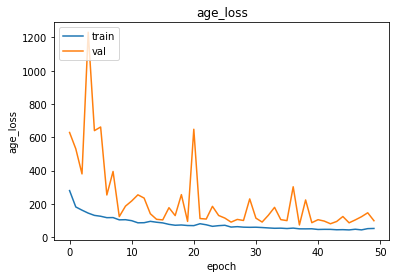

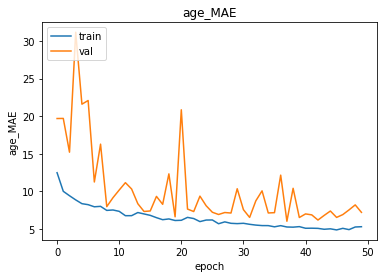

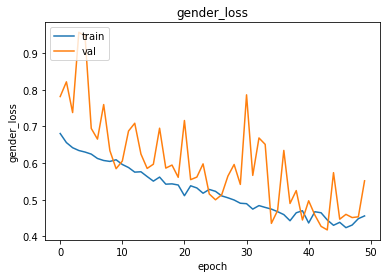

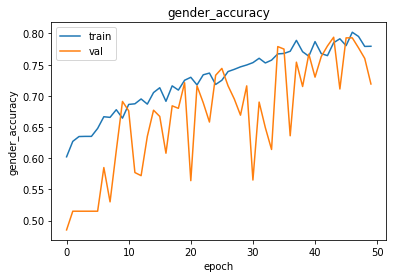

Model: InceptionV3


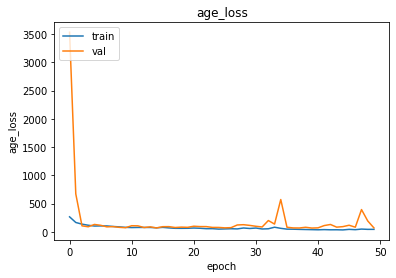

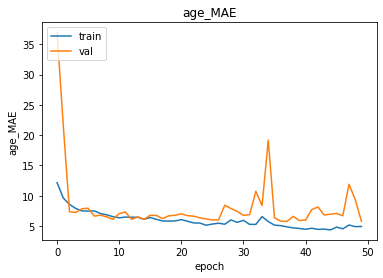

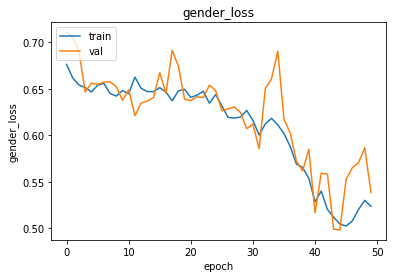

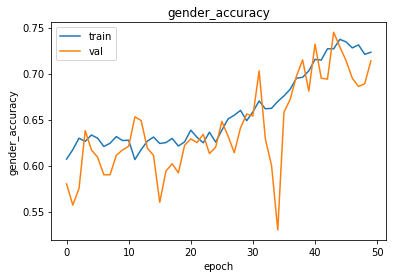

Model: MobileNet


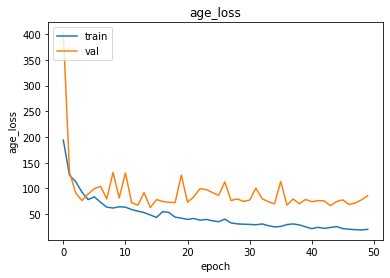

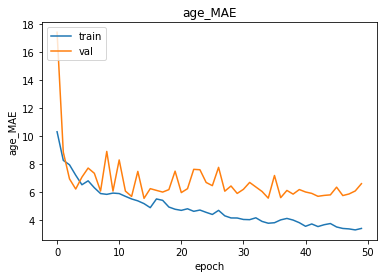

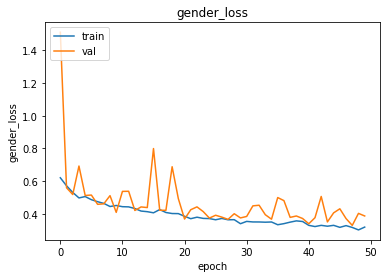

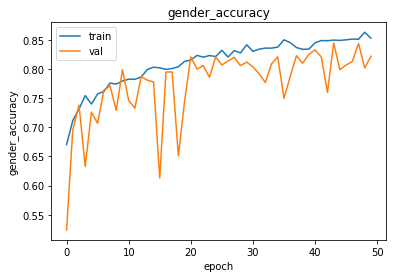

In [ ]:
print(histories)
i = 0
for history in histories:
  print("Model:", models[i][0])
  plt.plot(history.history['age_output_loss'])
  plt.plot(history.history['val_age_output_loss'])
  plt.title('age_loss')
  plt.ylabel('age_loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


  plt.plot(history.history['age_output_MAE'])
  plt.plot(history.history['val_age_output_MAE'])
  plt.title('age_MAE')
  plt.ylabel('age_MAE')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['gender_output_loss'])
  plt.plot(history.history['val_gender_output_loss'])
  plt.title('gender_loss')
  plt.ylabel('gender_loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['gender_output_accuracy'])
  plt.plot(history.history['val_gender_output_accuracy'])
  plt.title('gender_accuracy')
  plt.ylabel('gender_accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  i += 1


In [ ]:
from sklearn.metrics import mean_absolute_error, accuracy_score
import numpy as np
from keras.models import load_model

for name, model in models:
  print("Testing", name)
  model = load_model(name+"age_gender_B.h5")

  # Evaluate the model on the test data
  loss, age_loss, gender_loss, age_mae, gender_acc = (model.evaluate(x_val, [y_val[0], y_val[1]]))

  # Print the loss and metric values for each output
  print('Total loss: {:.4f}'.format(loss))
  print('Age loss: {:.4f}, Age MAE: {:.4f}'.format(age_loss, age_mae))
  print('Gender loss: {:.4f}, Gender accuracy: {:.4f}'.format(gender_loss, gender_acc))


Testing ResNet50
32/32 [==============================] - 2s 38ms/step - loss: 99.7293 - age_output_loss: 99.1778 - gender_output_loss: 0.5516 - age_output_MAE: 7.1961 - gender_output_accuracy: 0.7190
Total loss: 99.7293
Age loss: 99.1778, Age MAE: 7.1961
Gender loss: 0.5516, Gender accuracy: 0.7190
Testing InceptionV3
32/32 [==============================] - 3s 35ms/step - loss: 69.8884 - age_output_loss: 69.3499 - gender_output_loss: 0.5385 - age_output_MAE: 5.7745 - gender_output_accuracy: 0.7140
Total loss: 69.8884
Age loss: 69.3499, Age MAE: 5.7745
Gender loss: 0.5385, Gender accuracy: 0.7140
Testing MobileNet
32/32 [==============================] - 1s 17ms/step - loss: 86.1472 - age_output_loss: 85.7606 - gender_output_loss: 0.3866 - age_output_MAE: 6.5755 - gender_output_accuracy: 0.8220
Total loss: 86.1472
Age loss: 85.7606, Age MAE: 6.5755
Gender loss: 0.3866, Gender accuracy: 0.8220


In [ ]:
#Using Keras Tuner to find preferable hyperparameters
!pip install keras-tuner
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNet, InceptionV3
from tensorflow.keras.optimizers import Adam
import kerastuner as kt
from keras.regularizers import l2

# Define the model architecture
def build_model(hp):
    # Select pre-trained model
    base_model = hp.Choice('base_model', ['InceptionV3', 'MobileNet'])
    if base_model == 'InceptionV3':
        base = InceptionV3
    else:
        base = MobileNet

    base_model = base(weights = 'imagenet', # the model if pre-trained on ImageNet
                  include_top = False, # do not include the FC layers
                  input_shape = (128, 128,3))


    # Set the early layers to non-trainable
    for layer in base_model.layers[:14]:
        layer.trainable = False

    # Add the top layers
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    # Define the age branch
    age_branch = layers.Dense(units=hp.Choice('age_units',  values=[125, 256, 512], default=512), activation='relu', kernel_regularizer=l2(hp.Float('reg_1', min_value=0.01, max_value=0.05, default=0.01, step=0.01)))(x)
    age_branch = layers.Dropout(hp.Float('age_dropout', min_value=0.1, max_value=0.3, step=0.1)) (age_branch)
    age_branch = layers.Dense(units=hp.Choice('age_units2',  values=[125, 256, 512], default=256), activation='relu', kernel_regularizer=l2(hp.Float('reg_2', min_value=0.01, max_value=0.05, default=0.01, step=0.01)))(age_branch)
    age_branch = layers.Dropout(hp.Float('age_dropout2', min_value=0.1, max_value=0.3, step=0.1)) (age_branch)
    age_output = layers.Dense(1, activation='linear', name='age_output')(age_branch)

    # Define the gender branch
    gender_branch = layers.Dense(units=hp.Choice('gender_units',  values=[125, 256, 512], default=512), activation='relu', kernel_regularizer=l2(hp.Float('reg_3', min_value=0.01, max_value=0.05, default=0.01, step=0.01)))(x)
    gender_branch = layers.Dropout(hp.Float('gender_dropout', min_value=0.1, max_value=0.3, step=0.1)) (gender_branch)
    gender_branch = layers.Dense(units=hp.Choice('gender_units2',  values=[125, 256, 512], default=512), activation='relu', kernel_regularizer=l2(hp.Float('reg_4', min_value=0.01, max_value=0.05, default=0.01, step=0.01)))(gender_branch)
    gender_branch = layers.Dropout(hp.Float('gender_dropout2', min_value=0.1, max_value=0.3, step=0.1)) (gender_branch)
    gender_branch = layers.Dense(units=hp.Choice('gender_units3',  values=[125, 256, 512], default=256), activation='relu', kernel_regularizer=l2(hp.Float('reg_5', min_value=0.01, max_value=0.05, default=0.01, step=0.01)))(gender_branch)
    gender_branch = layers.Dropout(hp.Float('gender_dropout3', min_value=0.1, max_value=0.3, step=0.1)) (gender_branch)
    gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(gender_branch)

    # Create the model
    model = keras.models.Model(inputs=base_model.input, outputs=[age_output, gender_output])

    # Compile the model
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'},
                  metrics={'age_output': 'mae', 'gender_output': 'accuracy'})

    return model

from kerastuner import RandomSearch
# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='my_project'
)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.8 MB/s eta 0:00:00


<ipython-input-7-bdd91712bf25>:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
from kerastuner import RandomSearch
# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='my_project'
)


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpointer = ModelCheckpoint("best_age_gender_B.h5", monitor='val_loss',verbose=1,save_best_only=True)
early_stop= EarlyStopping(patience=50, monitor='val_loss',restore_best_weights=True),
callback_list=[checkpointer,early_stop]

batch_size = 32

tuner.search(train_generated,
             steps_per_epoch= x_train.shape[0] // batch_size,
             epochs=10,
             validation_data=(x_val, (y_val[0],y_val[1])), 
             callbacks=callback_list)

Trial 10 Complete [00h 06m 29s]
val_loss: 186.21766662597656

Best val_loss So Far: 75.84166717529297
Total elapsed time: 01h 06m 48s


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 32)   128         ['conv1[0][0]']                  
                                                                                                  
 conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['conv1_bn[0][0]']         

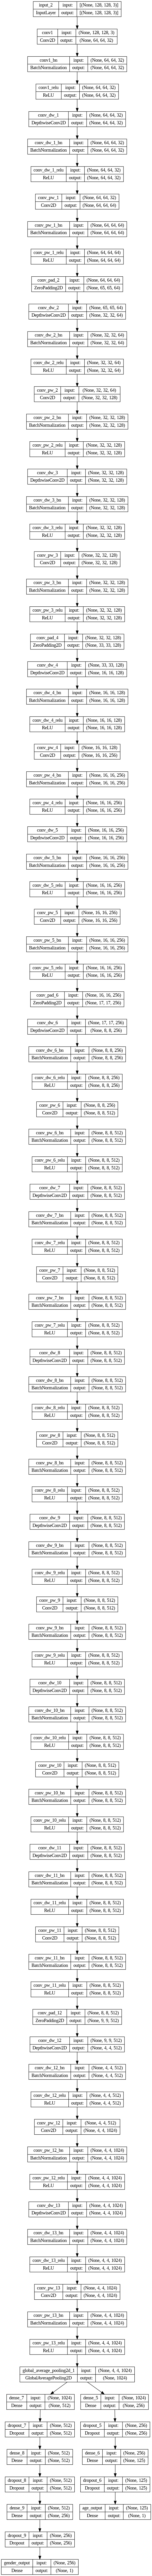

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
modelB = build_model(best_hps)

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)


In [7]:
from tensorflow.keras.regularizers import l2
from keras.applications import VGG16, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Concatenate, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

base_model = MobileNet(weights = 'imagenet', # the model if pre-trained on ImageNet
              include_top = False, # do not include the FC layers
              input_shape = (128, 128,3))


# Set the early layers to non-trainable
for layer in base_model.layers[:14]:
    layer.trainable = False

# Add the top layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)

# Define the age branch
age_branch = layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.01))(x)
age_branch = layers.Dropout(0.3) (age_branch)
age_branch = layers.Dense(units=128, activation='relu', kernel_regularizer=l2(0.01))(age_branch)
age_branch = layers.Dropout(0.3) (age_branch)
age_output = layers.Dense(1, activation='linear', name='age_output')(age_branch)

# Define the gender branch
gender_branch = layers.Dense(units=512, activation='relu', kernel_regularizer=l2(0.02))(x)
gender_branch = layers.Dropout(0.1) (gender_branch)
gender_branch = layers.Dense(units=512, activation='relu', kernel_regularizer=l2(0.02))(gender_branch)
gender_branch = layers.Dropout(0.1) (gender_branch)
gender_branch = layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.02))(gender_branch)
gender_branch = layers.Dropout(0.1) (gender_branch)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(gender_branch)

# Create the model
modelB = Model(inputs=base_model.input, outputs=[age_output, gender_output])

# Compile the model
modelB.compile(optimizer=Adam(0.001),
              loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'},
              metrics={'age_output': 'mae', 'gender_output': 'accuracy'})

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)


17225924/17225924 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 32)   128         ['conv1[0][0]']                  
                                                                                                  
 conv1_relu (ReLU)           

In [8]:
#Fitting the Model
batch_size = 32
history = modelB.fit(train_generated,
                        steps_per_epoch= x_train.shape[0] // batch_size,
                        epochs=150,
                        validation_data=(x_val, (y_val[0],y_val[1])))

Epoch 1/150
125/125 [==============================] - 60s 254ms/step - loss: 258.4475 - age_output_loss: 244.2945 - gender_output_loss: 0.6156 - age_output_mae: 11.6648 - gender_output_accuracy: 0.6630 - val_loss: 171.1243 - val_age_output_loss: 163.7290 - val_gender_output_loss: 1.0442 - val_age_output_mae: 10.7466 - val_gender_output_accuracy: 0.4860
Epoch 2/150
125/125 [==============================] - 32s 257ms/step - loss: 157.9741 - age_output_loss: 151.5573 - gender_output_loss: 0.6013 - age_output_mae: 9.1247 - gender_output_accuracy: 0.6833 - val_loss: 109.1409 - val_age_output_loss: 102.8444 - val_gender_output_loss: 0.7783 - val_age_output_mae: 7.4316 - val_gender_output_accuracy: 0.5620
Epoch 3/150
125/125 [==============================] - 32s 258ms/step - loss: 152.6839 - age_output_loss: 146.7226 - gender_output_loss: 0.6017 - age_output_mae: 8.9252 - gender_output_accuracy: 0.6808 - val_loss: 141.3289 - val_age_output_loss: 135.5085 - val_gender_output_loss: 0.5975 - 

In [9]:
import os

model_folder = '/content/drive/MyDrive/Colab Notebooks/models'
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
modelB.save(model_folder+'/age_gender_B.h5')  

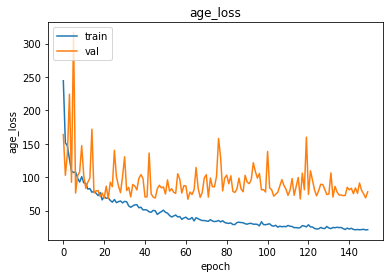

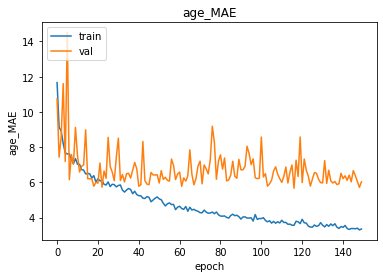

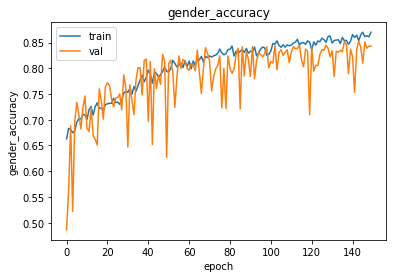

In [10]:
plt.plot(history.history['age_output_loss'])
plt.plot(history.history['val_age_output_loss'])
plt.title('age_loss')
plt.ylabel('age_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(history.history['age_output_mae'])
plt.plot(history.history['val_age_output_mae'])
plt.title('age_MAE')
plt.ylabel('age_MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.title('gender_loss')
plt.ylabel('gender_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('gender_accuracy')
plt.ylabel('gender_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

In [11]:
#
# Add your code here
#
# for name, model in models:
# print("Testing", name)
# model = load_model(name+"age_gender_B.h5")

# Evaluate the model on the test data
loss, age_loss, gender_loss, age_mae, gender_acc = (modelB.evaluate(x_val, [y_val[0], y_val[1]]))

# Print the loss and metric values for each output
print('Total loss: {:.4f}'.format(loss))
print('Age loss: {:.4f}, Age MAE: {:.4f}'.format(age_loss, age_mae))
print('Gender loss: {:.4f}, Gender accuracy: {:.4f}'.format(gender_loss, gender_acc))

32/32 [==============================] - 1s 18ms/step - loss: 79.0530 - age_output_loss: 78.0983 - gender_output_loss: 0.3446 - age_output_mae: 6.0303 - gender_output_accuracy: 0.8430
Total loss: 79.0530
Age loss: 78.0983, Age MAE: 6.0303
Gender loss: 0.3446, Gender accuracy: 0.8430


## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#